In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, LabelEncoder

from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv('Medical_appointment.csv')

In [3]:
def standard_scaling(X):
    for feature in num_features:
        X[feature] = (X[feature] - X[feature].mean()) / X[feature].std()
    return X    

In [4]:

num_features = data.select_dtypes(include=['int64', 'float64']).columns
cat_features = data.select_dtypes(include=['object']).columns
# missing values 
data[num_features] = data[num_features].fillna(data[num_features].mean())
data[cat_features] = data[cat_features].fillna(data[cat_features].mode().iloc[0])

label_encoder = LabelEncoder()
for feature in cat_features:
    data[feature] = label_encoder.fit_transform(data[feature])

X = data.drop('No-show', axis=1)
Y = data['No-show']

X = standard_scaling(X)

smote = SMOTE(random_state=42)

X, Y = smote.fit_resample(X, Y)

print("Class distribution after SMOTE:")
print(pd.Series(Y).value_counts())


Class distribution after SMOTE:
No-show
0    88208
1    88208
Name: count, dtype: int64


In [5]:
def split_data(X, y, ratio, random_seed=42):
    np.random.seed(random_seed)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    test_size = int(len(X) * ratio)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    X_train , X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train , y_test = y.iloc[train_indices], y.iloc[test_indices]

    return X_train, X_test, y_train, y_test
    

X_train , X_test , Y_train , Y_test =  split_data(X, Y, ratio=0.2)
# print("Initial X shape:", X.shape)
# print("Training set shape:", X_train.shape, Y_train.shape)
# print("Testing set shape:", X_test.shape, Y_test.shape)

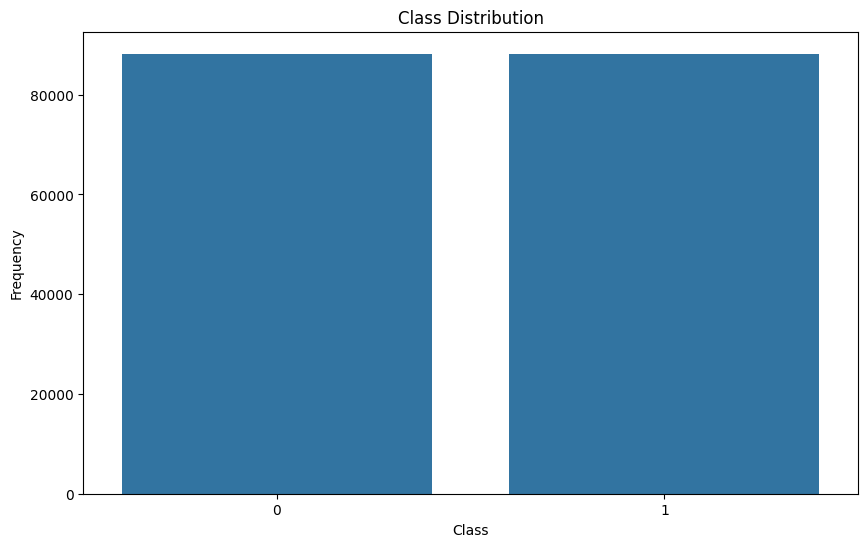

In [6]:
labels = pd.Series(Y.squeeze())
plt.figure(figsize=(10, 6))
sns.countplot(x=labels)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [7]:
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)
Y_train_np = Y_train.values.astype(np.float32)
Y_test_np = Y_test.values.astype(np.float32)


X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_train = torch.tensor(Y_train_np, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(Y_test_np, dtype=torch.float32).reshape(-1, 1)

In [8]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(MLP, self).__init__()
        layers = []
        # self.in_to_hid = nn.Linear(input_size, hidden_size)
        # self.hid_to_hid = nn.Linear(hidden_size, hidden_size)
        # self.hid_to_out = nn.Linear(hidden_size, output_size)
        # layers.append(in_to_hid)
        # layers.append(nn.ReLU())5
        _in = input_size
        for hidden_size in hidden_layers:
            _out = hidden_size
            layers.append(nn.Linear(_in,_out))
            layers.append(nn.ReLU())
            _in = _out
         
        layers.append(nn.Linear(_in,output_size))
        layers.append(nn.ReLU())   
        self.layers = nn.Sequential(*layers)
    def forward(self, X):
        return self.layers(X)
        
    

In [9]:
input_size = X_train.shape[1]
hidden_layers = []
for i in range (1): #20 layers
    hidden_layers.append(64)
    hidden_layers.append(32)
output_size = 1
learning_rate = 0.0001
num_epochs = 10
batch_size = 64
dropout_prob = 0.2

In [10]:
model = MLP(input_size, hidden_layers, output_size)

In [11]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
def MSE_Loss(y_pred, y_target):
    return torch.mean((y_target-y_pred)**2)
    
def MAE_Loss(y_pred, y_target):
    return torch.mean(np.abs(y_target - y_pred))

def R_squared_Loss(y_pred, y_target):
    a = ((y_target - y_pred)**2).sum()
    b = ((y_target - torch.mean(y_target))**2).sum()
    return 1 - (a / b)

In [14]:
losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = MSE_Loss(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
    losses.append(total_loss/ len(train_loader.dataset))
    epoch_loss = total_loss / len(train_loader.dataset)
    print(epoch+1, ": ", round(epoch_loss, 8))

1 :  67.52194738
2 :  0.50003897
3 :  0.50003897
4 :  0.50003897
5 :  0.50003897
6 :  0.50003897
7 :  0.50003897
8 :  0.50003897
9 :  0.50003897
10 :  0.50003897


Text(0.5, 0, 'epoch')

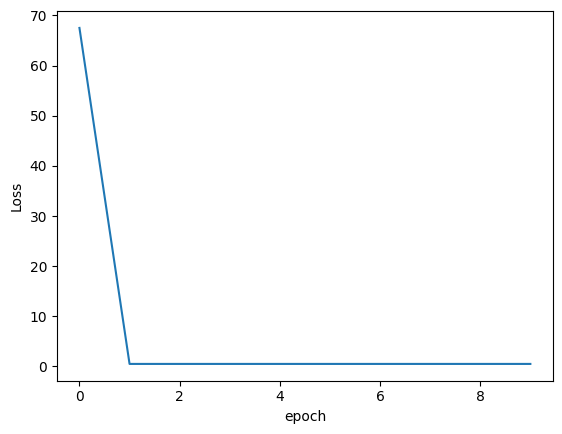

In [15]:
plt.plot(range(num_epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch')

In [16]:
def plotting(arr, epochs, name):
    plt.plot(range(epochs), arr)
    plt.ylabel(name)
    plt.xlabel('epoch')

def plot_losses(losses, epochs):
    plt.figure(figsize=(8, 5))
    plt.plot(range(epochs), losses, color='blue', label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracies(accuracies, epochs):
    plt.figure(figsize=(8, 5))
    plt.plot(range(epochs), accuracies, color='red', label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracies over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()